In [ ]:
!pip install numpy tqdm scikit-learn matplotlib seaborn mistralai 

In [1]:
import time
import random
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from mistralai.client import MistralClient

# Fetch & Process Data

In [2]:
# Fetch the test dataset to keep the download time short, it takes a few seconds on an average network connection.
newsgroups = fetch_20newsgroups(subset='test')
len(newsgroups['data'])

7532

To keep this example manageable, we'll select a subset of this data. First we'll select just five of the twenty categories to produce a smaller dataset we'll call 5newsgroups. Then we'll select a random sample of 200 items from 5newsgroups. Change this if you want more.

In [3]:
RANDOM_SAMPLE_SIZE = 200

In [4]:
# We'll select these five categories as they make a diverse set!
categories_to_select = {
    'talk': 'talk.politics.mideast',
    'sci': 'sci.space',
    'comp': 'comp.graphics',
    'rec': 'rec.sport.hockey',
    'soc': 'soc.religion.christian'
}

# Create a smaller dataset by filtering for data/targets belonging to the above categories.
selected_targets = [newsgroups.target_names.index(cat) for cat in categories_to_select.values()]
fivenewsgroups = [(text, target) for text, target in zip(newsgroups['data'], newsgroups['target']) if target in selected_targets]
categories = list(categories_to_select.values())

# Select 100 random instances from fivenewsgroups.
random_indices = random.sample(range(len(fivenewsgroups)), RANDOM_SAMPLE_SIZE)
text_documents = [fivenewsgroups[i][0] for i in random_indices]
targets = [fivenewsgroups[i][1] for i in random_indices]

# Generate Embeddings

Now we'll use the Mistral Embedding API to generate embeddings for our 100 documents. This takes about a minute on a standard network connection.

In [5]:
client = MistralClient(api_key="YOUR API KEY")

In [6]:
def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
          model="mistral-embed",
          input=input
      )
    
    return embeddings_batch_response.data[0].embedding

In [7]:
doc_embeddings = []
for doc in tqdm(text_documents):
   
    # Cap at 10,000 to avoid token size limit.
    if len(doc) > 10000:
       doc = doc[:10000]
        
    doc_embeddings.append(get_text_embedding(doc))
doc_embeddings = np.array(doc_embeddings)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:48<00:00,  1.19it/s]


# Visualise Embeddings

Let's first try to visualise our documents by projecting them into two dimensions with T-SNE. 

In [8]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
two_dim_projection = tsne.fit_transform(doc_embeddings)
x = [coord[0] for coord in two_dim_projection]
y = [coord[1] for coord in two_dim_projection]

Text(0, 0.5, 'Component 2')

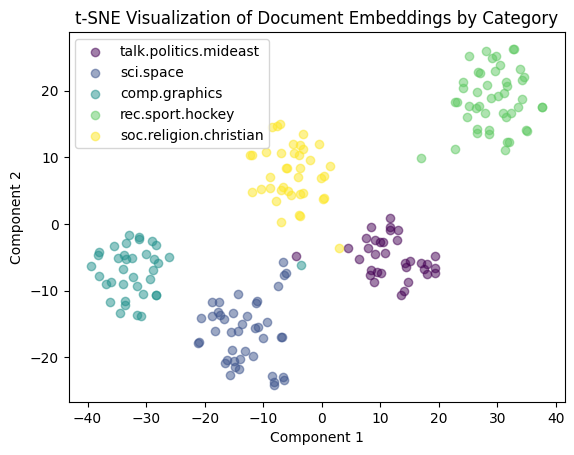

In [9]:
# Creates a nice set of colours for our visualisation.
base_cmap = matplotlib.colormaps.get_cmap('viridis')
colors = base_cmap(np.linspace(0, 1, len(categories)))  # Create a color range based on the number of categories
cmap = matplotlib.colors.ListedColormap(colors)

fig, ax = plt.subplots()
for idx, category in enumerate(categories):
    category_index = newsgroups.target_names.index(category)
    xs = [x[i] for i in range(len(x)) if targets[i] == category_index]
    ys = [y[i] for i in range(len(y)) if targets[i] == category_index]
    ax.scatter(xs, ys, color=cmap(idx), alpha=0.5, label=category)


ax.legend()
ax.set_title("t-SNE Visualization of Document Embeddings by Category")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")

# Clusters

Our visualisation shows that there are clearly some identifiable clusters so we'll use K Means to actually assign our documents to a cluster. First we'll fit our K Means clustering model.

In [10]:
k = len(categories)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(doc_embeddings)
cluster_labels = kmeans.labels_

Now we have cluster labels, and we want to see how they match up with our actual target labels. We have two problems though.

1. Our original targets were selected from twenty categories, so we need to map them into the range 1, 2, 3, 4, 5.
2. K Means does not know anything about our original labels, so the classes it predicts will not necessarily match the target classes.

Solving problem 2 is tricky without further processing, so we'll simply look for a strong correlation between cluster labels and target labels in the confusion matrix, but we won't demand that they lie on the diagonal axis.

In [11]:
unique_target_classes = sorted(set(targets))
class_mapping = {original_class: new_class for new_class, original_class in enumerate(unique_target_classes, start=0)}
transformed_targets = [class_mapping[item] for item in targets]

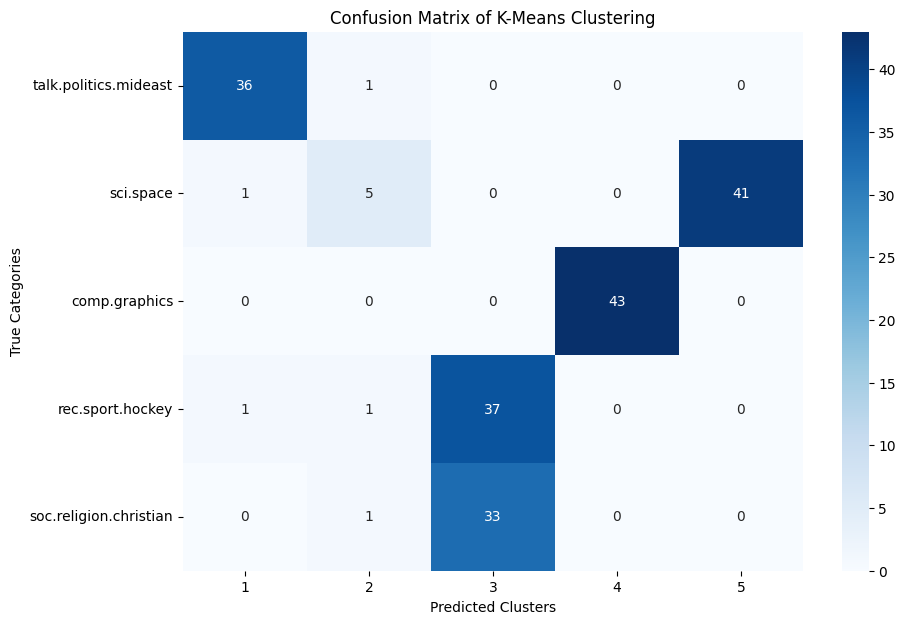

In [12]:
cm = confusion_matrix(transformed_targets, cluster_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, k+1), yticklabels=categories)
plt.xlabel('Predicted Clusters')
plt.ylabel('True Categories')
plt.title('Confusion Matrix of K-Means Clustering')
plt.show()